In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format="retina"

In [3]:
import numpy as np
from configparser import SafeConfigParser
from scipy.integrate import quad
from scipy import special
from scipy.special import j0
from scipy.interpolate import interp1d
from src.io import dict_from_section
import itertools

import glob
from scipy import integrate, interpolate
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import colossus, colossus.cosmology.cosmology
colossus.cosmology.cosmology.setCosmology('planck15')
from colossus.halo import profile_dk14
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable


In [4]:
import numpy as np
from configparser import SafeConfigParser
from scipy.integrate import quad
from scipy import special
from scipy.special import j0
from scipy.interpolate import interp1d
from src.io import dict_from_section

class Profiles(object):
    def __init__(self,iniFile="./input/params.ini",fwhm=1.4):

        Config = SafeConfigParser()
        Config.optionxform=str
        Config.read(iniFile)
        self.cc = dict_from_section(Config,'constants')
        self.pp = dict_from_section(Config,'params')

        self.TCMBmuK = self.cc['TCMB'] * 1e6

        self.XH = 0.76 ### FIX THIS INTO CONSTANTS ###
        self.NNR = 100
        self.disc_fac = np.sqrt(2)
        self.l0 = 30000. ### ell max
        self.fwhm = fwhm ### ARCMINS

        ### extrapolation variables
        self.inter_max = 5.
        self.inter_fine_fac = 40. #4.

        self.h = self.pp['H0']/100.
        self.om = (self.pp['ombh2']+self.pp['omch2'])/self.h**2

    #Hubble function
    def hub_func(self,z):
        Om = self.om
        Ol = 1 - Om
        #ans = np.sqrt(Om*(1.0 + z)**3 + Ol + (1 - O_tot)*(1 + z)**2)
        #FLAT LCDM
        ans = np.sqrt(Om*(1.0 + z)**3 + Ol)
        return ans

    #Comoving Distance Integrand
    def ComInt(self,z):
        ans = 1.0/self.hub_func(z)
        return ans

    #Comoving Distance
    def ComDist(self,z):
        Om = self.om 
        Ol = 1. - Om 
        O_tot = Om + Ol

        Dh = self.cc['C_OVER_HUBBLE']/self.h
        ans = Dh*quad(self.ComInt,0,z)[0]
        if (O_tot < 1.0): ans = Dh / np.sqrt(1.0-O_tot) *  np.sin(np.sqrt(1.0-O_tot) * quad(ComInt,0,z)[0])
        if (O_tot > 1.0): ans = Dh / np.sqrt(O_tot-1.0) *  np.sinh(np.sqrt(O_tot-1.0) * quad(ComInt,0,z)[0]) 
        return ans

    #Angular Distance
    def AngDist(self,z):
        ans = self.ComDist(z)/(1.0+z)
        return ans

    def project_prof_beam_interpol(self,tht,r200c,z,rho_sim,Pth_sim,test=False): #r200c in Mpc

        fwhm = self.fwhm

        drint = 1e-3 * (self.cc['MPC2CM'])
        AngDist = self.AngDist(z) * self.h
        disc_fac = self.disc_fac
        l0 = self.l0 
        NNR = self.NNR 
        NNR2 = 4*NNR
        
        fwhm *= np.pi / (180.*60.) #convert from arcmins to rads
        sigmaBeam = fwhm / np.sqrt(8.*np.log(2.))
        
        # JCH: convert r200c to Mpc/h units to match Nick's AngDist above
        r200c_Mpc_over_h = r200c * self.h

        sig = 0
        sig2 = 0
        sig_p = 0
        sig2_p = 0
        area_fac = 0
        
        r_ext = AngDist*np.arctan(np.radians(tht/60.))
        r_ext2 = AngDist*np.arctan(np.radians(tht*disc_fac/60.))
        
        rad = (np.arange(1e4) + 1.0)/1e3 #in MPC/h
        rad2 = (np.arange(1e4) + 1.0)/1e3 #in MPC/h
        
        radlim = r_ext
        radlim2 = r_ext2
        
        dtht = np.arctan(radlim/AngDist)/NNR # rads
        dtht2 = np.arctan(radlim2/AngDist)/NNR # rads
        
        thta = (np.arange(NNR) + 1.)*dtht
        thta2 = (np.arange(NNR) + 1.)*dtht2
        
        thta_smooth = (np.arange(NNR2) + 1.)*dtht
        thta2_smooth = (np.arange(NNR2) + 1.)*dtht2
        
        rho2D = thta_smooth * 0.0
        rho2D2 = thta_smooth * 0.0
        Pth2D = thta_smooth * 0.0
        Pth2D2 = thta_smooth * 0.0
        
        rho2D_beam = thta * 0.0
        rho2D2_beam = thta* 0.0
        Pth2D_beam = thta* 0.0
        Pth2D2_beam = thta* 0.0

        for kk in range(NNR2):
            rint  = np.sqrt((rad)**2  + thta_smooth[kk]**2 *AngDist**2)
            rint2 = np.sqrt((rad2)**2 + thta2_smooth[kk]**2*AngDist**2)

            if (test):
                rho2D[kk]  = np.sum(2.*self.rho_sim_test(theta_sim_rho,rint /r200c_Mpc_over_h)*drint)
                rho2D2[kk] = np.sum(2.*self.rho_sim_test(theta_sim_rho,rint2/r200c_Mpc_over_h)*drint)
                
                Pth2D[kk]  = np.sum(2.*self.Pth_sim_test(theta_sim_pth,rint /r200c_Mpc_over_h)*drint)
                Pth2D2[kk] = np.sum(2.*self.Pth_sim_test(theta_sim_pth,rint2/r200c_Mpc_over_h)*drint)
            else:
                rho2D[kk]  = np.sum(2.*rho_sim(rint /r200c_Mpc_over_h)*drint)
                rho2D2[kk] = np.sum(2.*rho_sim(rint2/r200c_Mpc_over_h)*drint)
                
                Pth2D[kk]  = np.sum(2.*Pth_sim(rint /r200c_Mpc_over_h)*drint)
                Pth2D2[kk] = np.sum(2.*Pth_sim(rint2/r200c_Mpc_over_h)*drint)
        
        for kk in range(NNR):

            special1 = special.iv(0, thta_smooth *thta[kk] / sigmaBeam**2)
            special2 = special.iv(0, thta2_smooth*thta2[kk]/ sigmaBeam**2)
            special1[np.where(special1 == np.inf)] = 1.e308
            special2[np.where(special2 == np.inf)] = 1.e308

            rho2D_beam[kk]  = np.sum(thta_smooth  * rho2D  * np.exp(-0.5*thta_smooth**2 /sigmaBeam**2)  
                                     * special1)*dtht
            rho2D2_beam[kk] = np.sum(thta2_smooth * rho2D2 * np.exp(-0.5*thta2_smooth**2/sigmaBeam**2)
                                     * special2)*dtht2
            Pth2D_beam[kk]  = np.sum(thta_smooth  * Pth2D  * np.exp(-0.5*thta_smooth**2 /sigmaBeam**2)  
                                     * special1)*dtht
            Pth2D2_beam[kk] = np.sum(thta2_smooth * Pth2D2 * np.exp(-0.5*thta2_smooth**2/sigmaBeam**2) 
                                     * special2)*dtht2

            area_fac += 2.0*np.pi*dtht*thta[kk]
        
            rho2D_beam[kk]  *= np.exp(-0.5*thta[kk]**2 /sigmaBeam**2) / sigmaBeam**2
            rho2D2_beam[kk] *= np.exp(-0.5*thta2[kk]**2/sigmaBeam**2) / sigmaBeam**2
            Pth2D_beam[kk]  *= np.exp(-0.5*thta[kk]**2 /sigmaBeam**2) / sigmaBeam**2
            Pth2D2_beam[kk] *= np.exp(-0.5*thta2[kk]**2/sigmaBeam**2) / sigmaBeam**2

        sig  = 2.0*np.pi*dtht *np.sum(thta *rho2D_beam) 
        sig2 = 2.0*np.pi*dtht2*np.sum(thta2*rho2D2_beam) 

        sig_all_beam = (2*sig - sig2) * 1e-3 * self.cc['SIGMA_T'] * self.TCMBmuK / self.cc['MP'] / (np.pi * np.radians(tht/60.)**2) #* ((2. + 2.*self.XH)/(3.+5.*self.XH)) 
        #sig_all_beam = (2*sig - sig2) * 1e-3 * self.cc.c['SIGMA_T'] / self.cc.c['ME'] / (np.pi * np.radians(tht/60.)**2) * ((2. + 2.*self.XH)/(3.+5.*self.XH)) 

        sig_p  = 2.0*np.pi*dtht*np.sum(thta*Pth2D_beam)
        sig2_p = 2.0*np.pi*dtht2*np.sum(thta2*Pth2D2_beam)

        # JCH: get rid of TCMB here so that results are in Compton-y units
        sig_all_p_beam = (2*sig_p - sig2_p) * self.cc['SIGMA_T']/(self.cc['ME']*self.cc['C']**2) / area_fac #* \
        #self.cc.c['TCMBmuK'] # muK #* ((2. + 2.*self.XH)/(3.+5.*self.XH))# muK

        sig_all_beam /= (self.h)
        sig_all_p_beam /= (self.h)

        return sig_all_beam, sig_all_p_beam #, sig_all_beam_cumul, sig_all_p_beam_cumul #JCH edit -- output cumulative profile as well

    def make_a_obs_profile_sim(self,thta_arc,r200c,z,rho_int,pres_int):
        rho = np.zeros(len(thta_arc))
        pth = np.zeros(len(thta_arc))
        for ii in range(len(thta_arc)):
            temp = self.project_prof_beam_interpol(thta_arc[ii],r200c,z,rho_int,pres_int)
            rho[ii] = temp[0]
            pth[ii] = temp[1]
        return rho,pth

    ### Input for model profiles should be electron density and electron pressure NOT total density or thermal pressure  
    def interpol_sim_profile(self,x,prof):
        #Including extrapolation
        if (np.max(x) < self.inter_max):
            fine_fac = self.inter_fine_fac
            xtr_inds = np.ceil(self.inter_max - np.max(x))
            xtr_inds = np.floor(self.inter_max - np.max(x))*fine_fac
            str_xtr = np.ceil(np.max(x)) + 1./fine_fac
            xtr = np.arange(xtr_inds)/fine_fac + str_xtr
            extend = np.poly1d(np.polyfit(x, np.log(prof), 3))

            ans = interp1d(np.append(x,xtr),np.append(prof,np.exp(extend(xtr))),kind='slinear',bounds_error=False,fill_value=0)
        else: 
            ans = interp1d(x,prof,kind='slinear',bounds_error=False,fill_value=0)
        return ans

    #### JUST FOR TESTING ####
    def rho_sim_test(self, x):
        theta = np.array([3.6337402156859753, 1.0369351928324118, 3.3290812595973063])
        ###Battaglia 2016 profile parameters w/o M & z dependences
        fb = 0.0490086879038/0.314992203163
        rhoc = 2.77525e2
        Msol_cgs = 1.989e33
        kpc_cgs = 3.086e21
        a1,a2,a3 = theta
        gamma = 0.2
        ans = 10**a1 / ((x/0.5)**gamma * (1 + (x/0.5)**a2)**((a3 - gamma)/a2))
        ans *=  rhoc * Msol_cgs / kpc_cgs / kpc_cgs / kpc_cgs * fb 
        return ans
    
    def pth_sim_test(self,x):
        theta = np.array([18.1, 0.5, 4.35])
        ###Battaglia et al 2012b profile paramters w/o M & z dependences
        P0,xc,bt = theta
        al = 1.0
        gm = 0.3
        ans = P0 / ((x*xc)**gm * (1 + (x*xc)**al)**((bt-gm)/al))
        return ans
    #### JUST FOR TESTING ####


In [23]:
### FISHER PLOTS

def marginal_pars(pars,fishmats,fishlab=None):
    #print out marginalized constraints
    diag = np.diagonal(fishmats)
    if (fishlab):
        for i in range(len(diag)):
            print (fishlab[i], pars[i],np.sqrt(diag[i]))
    else:
        for i in range(len(diag)):
            print (pars[i],np.sqrt(diag[i]))
    return
    
def make_circle(numpnts=360):
    xx = np.array(np.arange(numpnts) / 180. * np.pi)
    circl = np.array([np.cos(xx),np.sin(xx)])
    return circl

def make_elsp(chi2,chifac = 2.3):
    
    circ = make_circle()
    Lmat = np.linalg.cholesky(chi2)

    ans1sig = np.dot(np.sqrt(chifac)*Lmat,circ)
    ans2sig = np.dot(np.sqrt(2.0*chifac)*Lmat,circ)
    return ans1sig, ans2sig

def tri_plot(pars,fishmats,setNames,cols=itertools.repeat(None),lss=itertools.repeat(None),parlabs=itertools.repeat(None),saveFile="default.png",thk=3):
    #
    numpars = len(pars)
    print(numpars)
    plt.figure(figsize=(4*numpars,4*numpars))
    plt.rc('axes', linewidth=thk)
    
    print(np.shape(fishmats))
    bigcount = 0
    print(setNames)
    print(cols)
    print(lss)
    print(parlabs)
    for setName,col,ls,lab in zip(setNames,cols,lss,parlabs):
        if (len(setName) > 1):
            covmat = np.linalg.inv(fishmats[:][bigcount])
        else:
            covmat = np.linalg.inv(fishmats)
        for i in range(0,numpars):
            for j in range(i+1,numpars):
                count = 1+(j-1)*(numpars-1) + i
                chi2 = np.array([[covmat[i,i],covmat[i,j]],[covmat[j,i],covmat[j,j]]])
                ansout, ansout2 = make_elsp(chi2)
                plt.subplot(numpars-1,numpars-1,count)
                if (bigcount == 0): 
                    plt.tick_params(size=14,width=thk,labelsize = 16)
                    plt.plot(0,0,'xk',mew=thk)
#                     if (count ==1):
#                         plt.ylabel(lab[1][:], fontsize=32,weight='bold')
#                     if (count == 3):
#                         plt.ylabel(lab[2][:], fontsize=32,weight='bold')
#                         plt.xlabel(lab[0][:], fontsize=32,weight='bold')
#                     if (count == 4):
#                         plt.xlabel(lab[1][:], fontsize=32,weight='bold')
    
                plt.plot(ansout[0,:]/pars[i]*100. , ansout[1,:]/pars[j]*100.,ansout2[0,:]/pars[i]*100.,ansout2[1,:]/pars[j]*100.,'--',color=col,linewidth=thk)
#                plt.plot(ansout2[0,:]/pars[i]*100. , ansout2[1,:]/pars[j]*100.,'--',color=col,linewidth=thk)
        bigcount = bigcount + 1
        
    plt.savefig(saveFile, bbox_inches='tight',format='png')

    return



In [6]:

gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0   = 67.74*km/s/Mpc
Om   = 0.3075
OL = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
#OL      = 0.73
#Om      = 0.27
fb      = 0.158
keV     = 1.60218e-9

mu = 0.62
metallicity = 10**-0.5
muH = 1/0.75
redshift=0.0



"""
Cooling curve as a function of density, temperature, metallicity, redshift
"""
file = glob.glob('./data/Lambda_tab_redshifts.npz')
if len(file) > 0:
    data = np.load(file[0])
    Lambda_tab = data['Lambda_tab']
    redshifts  = data['redshifts']
    Zs         = data['Zs']
    log_Tbins  = data['log_Tbins']
    log_nHbins = data['log_nHbins']    
    Lambda      = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=0)
else:
    files = np.sort(glob.glob('/Users/dfielding/Dropbox (Simons Foundation)/Research/Tables/CoolingTables/z_*hdf5'))
    redshifts = np.array([float(f[-10:-5]) for f in files])
    HHeCooling = {}
    ZCooling   = {}
    TE_T_n     = {}
    for i in range(len(files)):
        f            = h5py.File(files[i], 'r')
        i_X_He       = -3 
        Metal_free   = f.get('Metal_free')
        Total_Metals = f.get('Total_Metals')
        log_Tbins    = np.array(np.log10(Metal_free['Temperature_bins']))
        log_nHbins   = np.array(np.log10(Metal_free['Hydrogen_density_bins']))
        Cooling_Metal_free       = np.array(Metal_free['Net_Cooling'])[i_X_He] ##### what Helium_mass_fraction to use    Total_Metals = f.get('Total_Metals')
        Cooling_Total_Metals     = np.array(Total_Metals['Net_cooling'])
        HHeCooling[redshifts[i]] = interpolate.RectBivariateSpline(log_Tbins,log_nHbins, Cooling_Metal_free)
        ZCooling[redshifts[i]]   = interpolate.RectBivariateSpline(log_Tbins,log_nHbins, Cooling_Total_Metals)
        f.close()
    Lambda_tab  = np.array([[[[HHeCooling[zz].ev(lT,ln)+Z*ZCooling[zz].ev(lT,ln) for zz in redshifts] for Z in Zs] for lT in log_Tbins] for ln in log_nHbins])
    np.savez('./data/Lambda_tab_redshifts.npz', Lambda_tab=Lambda_tab, redshifts=redshifts, Zs=Zs, log_Tbins=log_Tbins, log_nHbins=log_nHbins)
    Lambda      = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=0)
print("interpolated lambda")


interpolated lambda


In [7]:

def c_DuttonMaccio14(lMhalo, z=0):  #table 3 appropriate for Mvir
    c_z0  = lambda lMhalo: 10.**(1.025 - 0.097*(lMhalo-np.log10(0.7**-1*1e12))) 
    c_z05 = lambda lMhalo: 10.**(0.884 - 0.085*(lMhalo-np.log10(0.7**-1*1e12))) 
    c_z1  = lambda lMhalo: 10.**(0.775 - 0.073*(lMhalo-np.log10(0.7**-1*1e12))) 
    c_z2  = lambda lMhalo: 10.**(0.643 - 0.051*(lMhalo-np.log10(0.7**-1*1e12)))
    zs = np.array([0.,0.5,1.,2.])
    cs = np.array([c_func(lMhalo) for c_func in (c_z0,c_z05,c_z1,c_z2)])
    return np.interp(z, zs, cs)
def Behroozi_params(z, parameter_file='/Users/dfielding/Dropbox (Simons Foundation)/Research/Tables/umachine-edr/data/smhm/params/smhm_true_med_cen_params.txt'):
    param_file = open(parameter_file, "r")
    param_list = []
    allparams = []
    for line in param_file:
        param_list.append(float((line.split(" "))[1]))
        allparams.append(line.split(" "))
    
    if (len(param_list) != 20):
        print("Parameter file not correct length.  (Expected 20 lines, got %d)." % len(param_list))
        quit()
    
    names = "EFF_0 EFF_0_A EFF_0_A2 EFF_0_Z M_1 M_1_A M_1_A2 M_1_Z ALPHA ALPHA_A ALPHA_A2 ALPHA_Z BETA BETA_A BETA_Z DELTA GAMMA GAMMA_A GAMMA_Z CHI2".split(" ");
    params = dict(zip(names, param_list))
    
    
    #Print SMHM relation
    a = 1.0/(1.0+z)
    a1 = a - 1.0
    lna = np.log(a)
    zparams = {}
    zparams['m_1'] = params['M_1'] + a1*params['M_1_A'] - lna*params['M_1_A2'] + z*params['M_1_Z']
    zparams['sm_0'] = zparams['m_1'] + params['EFF_0'] + a1*params['EFF_0_A'] - lna*params['EFF_0_A2'] + z*params['EFF_0_Z']
    zparams['alpha'] = params['ALPHA'] + a1*params['ALPHA_A'] - lna*params['ALPHA_A2'] + z*params['ALPHA_Z']
    zparams['beta'] = params['BETA'] + a1*params['BETA_A'] + z*params['BETA_Z']
    zparams['delta'] = params['DELTA']
    zparams['gamma'] = 10**(params['GAMMA'] + a1*params['GAMMA_A'] + z*params['GAMMA_Z'])
    
    smhm_max = 14.5-0.35*z
    if (params['CHI2']>200):
        print('#Warning: chi^2 > 200 implies that not all features are well fit.  Comparison with the raw data (in data/smhm/median_raw/) is crucial.')
    ms = 0.05 * np.arange(int(10.5*20),int(smhm_max*20+1),1)
    dms = ms - zparams['m_1'] 
    dm2s = dms/zparams['delta']
    sms = zparams['sm_0'] - np.log10(10**(-zparams['alpha']*dms) + 10**(-zparams['beta']*dms)) + zparams['gamma']*np.e**(-0.5*(dm2s*dm2s))
    return ms,sms

def MgalaxyBehroozi(lMhalo, z, parameter_file='/Users/dfielding/Dropbox (Simons Foundation)/Research/Tables/umachine-edr/data/smhm/params/smhm_true_med_cen_params.txt'):
    ms,sms = Behroozi_params(z,parameter_file)
    lMstar = interpolate.interp1d(ms, sms, fill_value='extrapolate')(lMhalo)
    return 10.**lMstar*un.Msun


class DK14_with_Galaxy:
    mu=0.6
    X=0.75    
    gamma = 5/3.
    def __init__(self,Mgalaxy,half_mass_radius=None,dk14=None,**kwargs):
        if dk14!=None: 
            self.dk14=dk14
        else:
            self.dk14=colossus.halo.profile_dk14.getDK14ProfileWithOuterTerms(**kwargs)        
        self.Mgalaxy = Mgalaxy
        self.z = kwargs['z']
        if half_mass_radius==None: self.half_mass_radius = 0.015 * self.RDelta('200c') #Kravtsov 2013
        else: self.half_mass_radius = half_mass_radius

        self._Rs = 10.**np.arange(-4.,1.5,0.01) * self.rvir().to('kpc').value
        self._Ms = self.dk14.enclosedMass(self._Rs*cosmo.h) / cosmo.h  #only DM mass
        self._Ms += self.enclosedMass_galaxy(self._Rs*un.kpc).to('Msun').value
        drs = (self._Rs[2:]-self._Rs[:-2])/2.
        drs = np.pad(drs,1,mode='edge')
        self._phis = ((-self.g(self._Rs*un.kpc)[::-1].to('km**2*s**-2*kpc**-1').value * drs[::-1]).cumsum())[::-1]        
        
    def enclosedMass_galaxy(self,r):
        return self.Mgalaxy * r/(r+self.half_mass_radius)
    def enclosedMass(self,r):
        return np.interp(r.to('kpc').value, self._Rs, self._Ms)*un.Msun
    def enclosedMassInner(self,r):
        return self.dk14.enclosedMassInner(r.to('kpc').value*cosmo.h)*un.Msun / cosmo.h  #only DM mass
    def enclosedMassOuter(self,r):
        return self.dk14.enclosedMassOuter(r.to('kpc').value*cosmo.h)*un.Msun / cosmo.h  #only DM mass
    def g(self, r):
        return cons.G*self.enclosedMass(r) / r**2  
    def rvir(self):
        return self.dk14.RDelta(self.z,'vir') * un.kpc/cosmo.h
    def RDelta(self,mdef):
        return self.dk14.RDelta(self.z,mdef) * un.kpc/cosmo.h
    def Tvir(self):
        return (self.mu * cons.m_p * self.vc(self.rvir())**2 / (2*cons.k_B)).to('K')    
    def vc(self,r):
        return ((cons.G*self.enclosedMass(r) / r)**0.5).to('km/s')
    def Tc(self,r):
        return (self.mu*cons.m_p * self.vc(r)**2 / (self.gamma*cons.k_B)).to('K')
    def Mhalo(self):
        return self.dk14.MDelta(self.z,'vir')*un.Msun/cosmo.h
    def phi(self,rs,r0):
        phis = np.interp(rs.to('kpc').value, self._Rs, self._phis)
        phi0 = np.interp(r0.to('kpc').value, self._Rs, self._phis)        
        return (phis - phi0) * un.km**2/un.s**2
    def rho(self,r):
        return (self.dk14.density(r.to('kpc').value*cosmo.h) * un.Msun * cosmo.h**2 / un.kpc**3).to('g*cm**-3')
    def tff(self,r):
        return (2**0.5 * r/ self.vc(r)).to('Gyr')
    def rho_b(self,r):
        return self.rho(r) * cosmo.Ob0 / cosmo.Om0



#### Fit to Diemer+14 nu vs logMhalo ---- THIS ONLY works for z = 0
nus = np.array([0.720000,0.7777,0.845000,1.200000,1.845400,3.140000])
logMhalos = np.array([11.5,11.75,12.,13.,14.,15.])

In [8]:


lMhalo=12.
nu = np.interp(lMhalo, logMhalos, nus)


"""
gamma P / rho = cs^2 

vc^2 / cs^2 = fcs
"""
Mhalo = 10**lMhalo * Msun
z = 0.
Mgalaxy = MgalaxyBehroozi(lMhalo, z)
dk14    = DK14_with_Galaxy(Mgalaxy=Mgalaxy,z=z,M = 10.**lMhalo*cosmo.h, c = c_DuttonMaccio14(lMhalo,z), mdef = 'vir')
cnfw    = c_DuttonMaccio14(lMhalo,z)
rvir    = dk14.rvir().value
r200m   = dk14.RDelta('200m').value
rgal    = dk14.half_mass_radius.value

print ('Mhalo  = %e' % 10**lMhalo)
print ('cnfw  = %f' % cnfw)
print ('rvir  = %f' % rvir)
print ('r200m  = %f' % r200m)
print ('Mgal  = %e' % Mgalaxy.value)
print ('Rgal  = %f' % rgal)

#H0   = 67.74*km/s/Mpc
#Om   = 0.3075
rhom = (3 * H0**2 * Om * (1.+z)**3) / (8*np.pi*G)
rhoc = (3 * H0**2) / (8*np.pi*G)
rs   = rvir/cnfw * kpc
rho0 = Mhalo / (4 * np.pi * rs**3 * ( np.log(1.+cnfw) - cnfw/(1.+cnfw) ))
rt   = (1.9-0.18*nu)*r200m * kpc
a    = 5. * cnfw * r200m / rvir
b    = rs/rt

def grav_acc(r):
    # 1/r**2 d/dr(  r**2 g ) = 4 pi G rho
    # g(r) = integral ( 4 pi G rho_NFW r**2 ) / r**2
    # g_NFW(r) = integral ( 4 pi G rhos rs**2 x**2/(x*(1+x)**2)) / (rs**2  x**2 )
    # g_NFW(r) = 4 pi G rhos (1/(x+1) + log(x+1))|_0**x /x**2
    # g_NFW(r) = 4 pi G rhos (log(x+1)-x/(x+1)) /x**2


    # rho_DM = rhos / (x * (1+x)**2 ) / (1.0 + (rs/rt)**4  * x**4)**2 
    #        + rhom * ( (rs/5*rvir)**-1.5 * x**-1.5 + 1. )

    # rho_DM = rhos / (x * (1+x)**2 ) / (1.0 + b**4  * x**4)**2 
    #        + rhom * ( bb**-1.5 * x**-1.5 + 1. )
    x = r/rs
    g = 4. * np.pi * G * rs
    g *= ((64.*a**1.5*rhom*x**1.5 + 32.*rhom*x**3. + (96.*rho0)/((1. + b**4.)**2.*(1. + x)) - 
         (24.*rho0*(-1. + b**4.*(3. + x*(-4. + x*(3. - 2.*x + b**4.*(-1. + 2.*x))))))/((1. + b**4.)**2.*(1. + b**4.*x**4.)) + 
         (12.*b*(-5.*np.sqrt(2.) + b*(18. - 14.*np.sqrt(2.)*b + 12.*np.sqrt(2.)*b**3. - 16.*b**4. + 2.*np.sqrt(2.)*b**5. + np.sqrt(2.)*b**7. - 2.*b**8.))*rho0*
            np.arctan(1. - np.sqrt(2.)*b*x))/(1. + b**4.)**3. + 
         (6*rho0*(4.*(1. + b**4.)*(-5. + 3.*b**4.) + 2.*b**2.*(-9 + 8.*b**4. + b**8.)*np.pi - 
              2.*b*(-5.*np.sqrt(2.) + b*(-18. - 14.*np.sqrt(2.)*b + 12.*np.sqrt(2.)*b**3. + 16.*b**4. + 2.*np.sqrt(2.)*b**5. + np.sqrt(2.)*b**7. + 2.*b**8.))*
               np.arctan(1. + np.sqrt(2.)*b*x) + 16.*(1. - 7.*b**4.)*np.log(1. + x) + 4.*(-1. + 7.*b**4.)*np.log(1. + b**4.*x**4.) - 
              np.sqrt(2.)*b*(-5. + 14.*b**2. + 12.*b**4. - 2.*b**6 + b**8.)*(np.log(1. + b*x*(-np.sqrt(2.) + b*x)) - np.log(1. + b*x*(np.sqrt(2.) + b*x)))))/
          (1. + b**4.)**3.)/(96.*x**2.))

    g += G*Mgalaxy.value*Msun/(r*(r+rgal*kpc))

    return g

def vc(r):
    return np.sqrt(grav_acc(r)*r)

r_inner  = 0.1*rvir*kpc
r_outer  = rvir*kpc
radii    = np.linspace(r_inner,r_outer,100)
vc_outer = np.sqrt(r_outer*grav_acc(r_outer))



Mhalo  = 1.000000e+12
cnfw  = 10.965426
rvir  = 263.605030
r200m  = 324.862056
Mgal  = 3.268809e+10
Rgal  = 2.973030


In [9]:

class HSE:
    def __init__(self, f_cs_HSE = 2.0, f_cgm=0.1):
        self.f_cs_HSE = f_cs_HSE
        self.f_cgm = f_cgm

        def find_rho_ta_HSE(Mass,r_inner, r_outer):
            rho = lambda r: np.square(vc(r_outer) / vc(r)) * (r/r_outer)**(-gamma*self.f_cs_HSE)
            m_shell = lambda r: 4*np.pi*r**2 * rho(r)
            M_cgm = integrate.quad(m_shell,r_inner, r_outer)[0]
            return Mass/M_cgm

        self.rho_ta_HSE = find_rho_ta_HSE(self.f_cgm*Mhalo, 0.1*rvir*kpc, rvir*kpc)


    def rho(self,r):
        return self.rho_ta_HSE*np.square(vc(rvir*kpc) / vc(r)) * (r/(rvir*kpc))**(-gamma*self.f_cs_HSE)

    def n(self,r):
        return self.rho(r)/mu/mp

    def cs(self,r):
        return vc(r)/np.sqrt(self.f_cs_HSE)

    def T(self,r):
        return mu*mp*self.cs(r)**2/kb/gamma

    def P(self,r):
        return self.n(r) * self.T(r)

    def K(self,r):
        return self.T(r) * self.n(r)**(-2/3.)

    def tcool_P(self,T, P, metallicity):
        return 1.5 * (muH/mu)**2 * kb * T / ( P/T * Lambda((np.log10(P/T*(mu/muH)),np.log10(T), metallicity, redshift)))

    def M_enc(self,r):
        m_shell = lambda radius: 4*np.pi*radius**2 * self.rho(radius)
        M_cgm = integrate.quad(m_shell,0.1*rvir*kpc,r)[0]
        return M_cgm


In [10]:

class HSE_turb:
    """
    Mach = dv_turb/cs 
    """
    def __init__(self, f_cs_HSE_turb = 2.0, f_cgm=0.1, Mach=0.5):
        self.f_cs_HSE_turb = f_cs_HSE_turb
        self.f_cgm = f_cgm
        self.Mach = Mach
        def find_rho_ta_HSE_turb(Mass,r_inner, r_outer):
            rho = lambda r: np.square(vc(r_outer) / vc(r)) * (r/r_outer)**(-gamma*self.f_cs_HSE_turb / (1.0 + self.Mach**2))
            m_shell = lambda r: 4*np.pi*r**2 * rho(r)
            M_cgm = integrate.quad(m_shell,r_inner, r_outer)[0]
            return Mass/M_cgm

        self.rho_ta_HSE_turb = find_rho_ta_HSE_turb(self.f_cgm*Mhalo, 0.1*rvir*kpc, rvir*kpc)


    def rho(self,r):
        return self.rho_ta_HSE_turb*np.square(vc(rvir*kpc) / vc(r)) * (r/(rvir*kpc))**(-gamma*self.f_cs_HSE_turb/ (1.0 + self.Mach**2))

    def n(self,r):
        return self.rho(r)/mu/mp

    def cs(self,r):
        return vc(r)/np.sqrt(self.f_cs_HSE_turb)

    def T(self,r):
        return mu*mp*self.cs(r)**2/kb/gamma

    def P(self,r):
        return self.n(r) * self.T(r)

    def K(self,r):
        return self.T(r) * self.n(r)**(-2/3.)

    def tcool_P(self,T, P, metallicity):
        return 1.5 * (muH/mu)**2 * kb * T / ( P/T * Lambda((np.log10(P/T*(mu/muH)),np.log10(T), metallicity, redshift)))

    def M_enc(self,r):
        m_shell = lambda radius: 4*np.pi*radius**2 * self.rho(radius)
        M_cgm = integrate.quad(m_shell,0.1*rvir*kpc,r)[0]
        return M_cgm


In [11]:

class HSE_adiabat:
    def __init__(self, f_Kvir = 1.0, f_cgm=0.1):
        self.f_Kvir = f_Kvir
        self.f_cgm = f_cgm

        self.K0 = self.f_Kvir * 0.5*vc(rvir*kpc)**2 * ((fb * Mhalo / (4 * np.pi/3. * (rvir*kpc)**3))**(-2./3.))

        def find_rho_ta_HSE_adiabat(Mass,r_inner, r_outer):
            rho = lambda r, rho_0: (rho_0**(2/3.) + (gamma-1)/(gamma* self.K0) * integrate.quad(grav_acc, r, rvir*kpc)[0])**(3/2.)
            m_shell = lambda r, rho_0: 4*np.pi*r**2 * rho(r, rho_0)
            rho_0s = np.logspace(-33,-23)
            M_cgms = np.zeros_like(rho_0s)
            for i in range(len(rho_0s)):
                M_cgms[i] = integrate.quad(m_shell,r_inner, r_outer, args=(rho_0s[i]))[0]

            return np.interp(Mass, M_cgms, rho_0s)

        self.rho_ta_HSE_adiabat = find_rho_ta_HSE_adiabat(self.f_cgm*Mhalo, 0.1*rvir*kpc, rvir*kpc)

        self.rho = np.vectorize(self.rho_unvec)


    def rho_unvec(self,r):
        return (self.rho_ta_HSE_adiabat**(2/3.) + (gamma-1)/(gamma*self.K0) * integrate.quad(grav_acc, r, rvir*kpc)[0])**(3/2.)   

    def n(self,r):
        return self.rho(r)/mu/mp

    def K(self,r):
        return self.K0 * np.ones_like(r)/kb * (mu*mp)**(gamma)

    def cs(self,r):
        return np.sqrt(gamma * self.K0 * self.rho(r)**(gamma-1))

    def T(self,r):
        return mu*mp*self.cs(r)**2/kb/gamma

    def P(self,r):
        return self.n(r) * self.T(r)

    def tcool_P(self,T, P, metallicity):
        return 1.5 * (muH/mu)**2 * kb * T / ( P/T * Lambda((np.log10(P/T*(mu/muH)),np.log10(T), metallicity, redshift)))

    def M_enc(self,r):
        m_shell = lambda radius: 4*np.pi*radius**2 * self.rho(radius)
        M_cgm = integrate.quad(m_shell,0.1*rvir*kpc,r)[0]
        return M_cgm



In [12]:

class cooling_flow:
    def __init__(self, f_cs_CF = 2.0, Mdot = -3.0 * Msun/yr, v0 = 1e5 , N_radii = 1e3):
        self.f_cs_CF = f_cs_CF
        self.Mdot = Mdot
        self.v0 = v0
        self.N_radii = N_radii
        TT = lambda r: mu*mp*vc(r)**2 / self.f_cs_CF / gamma /kb
        def dlogrhodlogr(logrho,logr):
            r = np.exp(logr)
            rho = np.exp(logrho)
            vr = self.Mdot/(4*np.pi*r**2*rho)
            return (self.f_cs_CF - (2/3.)*(r*Lambda((np.log10(rho/muH/mp), np.log10(TT(r)), metallicity, 0.0))*rho) / ( vr * vc(r)**2 * (mu*mp)**2 ) - 2.0) / ( (vr/vc(r))**2 * self.f_cs_CF - 1.0 ) - 2.0

        def rho_coolingflow(r_inner=0.05*rvir*kpc, r_outer=2.0*rvir*kpc, rho_inner = Mhalo/(rvir*kpc)**3):
            logr0 = np.log(r_inner)
            logrmax = np.log(r_outer)
            logrho0 = np.log(rho_inner)

            logrs=[logr0]
            logrhos=[logrho0]

            dlogr = (logrmax - logr0)/N_radii

            while logrs[-1] <= logrmax:
                logrhos.append(logrhos[-1]+dlogr*dlogrhodlogr(logrhos[-1],logrs[-1]))
                logrs.append(logrs[-1]+dlogr)
            return np.exp(logrhos), np.exp(logrs)

        self.rho_cf, self.r_cf = rho_coolingflow(r_inner = 0.05*rvir*kpc, 
                                                 r_outer = 2.0*rvir*kpc, 
                                                 rho_inner = -1.0*self.Mdot/(4*np.pi*(0.05*rvir*kpc)**2 * self.v0))#2*Mhalo/(rvir*kpc)**3)


    def T(self,r):
        return mu*mp*vc(r)**2 / self.f_cs_CF / gamma /kb

    def rho(self,r):
        return np.interp(r,self.r_cf,self.rho_cf)

    def n(self,r):
        return np.interp(r,self.r_cf,self.rho_cf)/(mu*mp)

    def vr(self,r):
        return self.Mdot/(4.*np.pi*r**2*self.rho(r))

    def K(self,r):
        return self.T(r) * (self.n(r))**(-2/3.)

    def P(self,r):
        return self.T(r) * self.n(r)


In [13]:

class precipitate:
    def __init__(self, tcooltff=10.0, T_outer=0.25*mu*mp*vc(rvir*kpc)**2/kb):
        self.tcooltff = tcooltff
        self.T_outer = T_outer

        logrs = np.linspace(np.log(0.001*rvir*kpc), np.log(2.1*rvir*kpc),500)
        vc2 = (np.max(vc(np.exp(logrs))))**2
        logTs = np.log(np.logspace(4.2,8,100))

        cooling_slope = interpolate.interp1d(logTs, np.gradient(np.log10(Lambda((-1, np.log10(np.exp(logTs)), metallicity, 0.0))))/np.gradient(logTs) )
        vc_slope = interpolate.interp1d( logrs , np.gradient(np.log10(vc(np.exp(logrs)))) / np.gradient(logrs))

        def dlogTdlogr(logT,logr):
            return (1.0 - vc_slope(logr) - mu * mp * vc(np.exp(logr))**2 / (kb*np.exp(logT)))/(2.0 - cooling_slope(logT))

        def T_precip(r_inner=0.01*rvir*kpc, r_outer=2.0*rvir*kpc, T_outer = self.T_outer):
            logr0 = np.log(r_outer)
            logrmin = np.log(r_inner)
            logT0 = np.log(T_outer)

            logrs=[logr0]
            logTs=[logT0]

            dlogr = -(np.log(r_outer) - np.log(r_inner))/1e3

            while logrs[-1] >= logrmin:
                logTs.append(logTs[-1]+dlogr*dlogTdlogr(logTs[-1],logrs[-1]))
                logrs.append(logrs[-1]+dlogr)
            return np.exp(logTs), np.exp(logrs)

        self.T_precip, self.r_precip = T_precip(r_inner=0.01*rvir*kpc, r_outer=2.0*rvir*kpc, T_outer = self.T_outer)

    def T(self,r):
        return np.interp(r,self.r_precip[::-1], self.T_precip[::-1])

    def rho(self,r):
        return 1.5*mu*mp*kb*self.T(r)*vc(r)/(Lambda((-1,np.log10(self.T(r)),metallicity,0.0))* self.tcooltff * r )

    def n(self,r):
        return self.rho(r)/(mu*mp)

    def K(self,r):
        return self.T(r) * (self.n(r))**(-2/3.)

    def P(self,r):
        return self.T(r) * self.n(r)



In [14]:
### TODO COSMIC RAY DIFFUSION LIMITED HALO FROM JI HOPKINS + 19

In [15]:
HSE_halo = HSE(1.0,0.1)
HSE_adiabat_halo = HSE_adiabat(1.5,0.1)
cooling_flow_halo = cooling_flow(1.25,-4.0*Msun/yr, 10e5,2e3)
precipitate_halo = precipitate(3.0,0.25*mu*mp*vc(rvir*kpc)**2/kb)

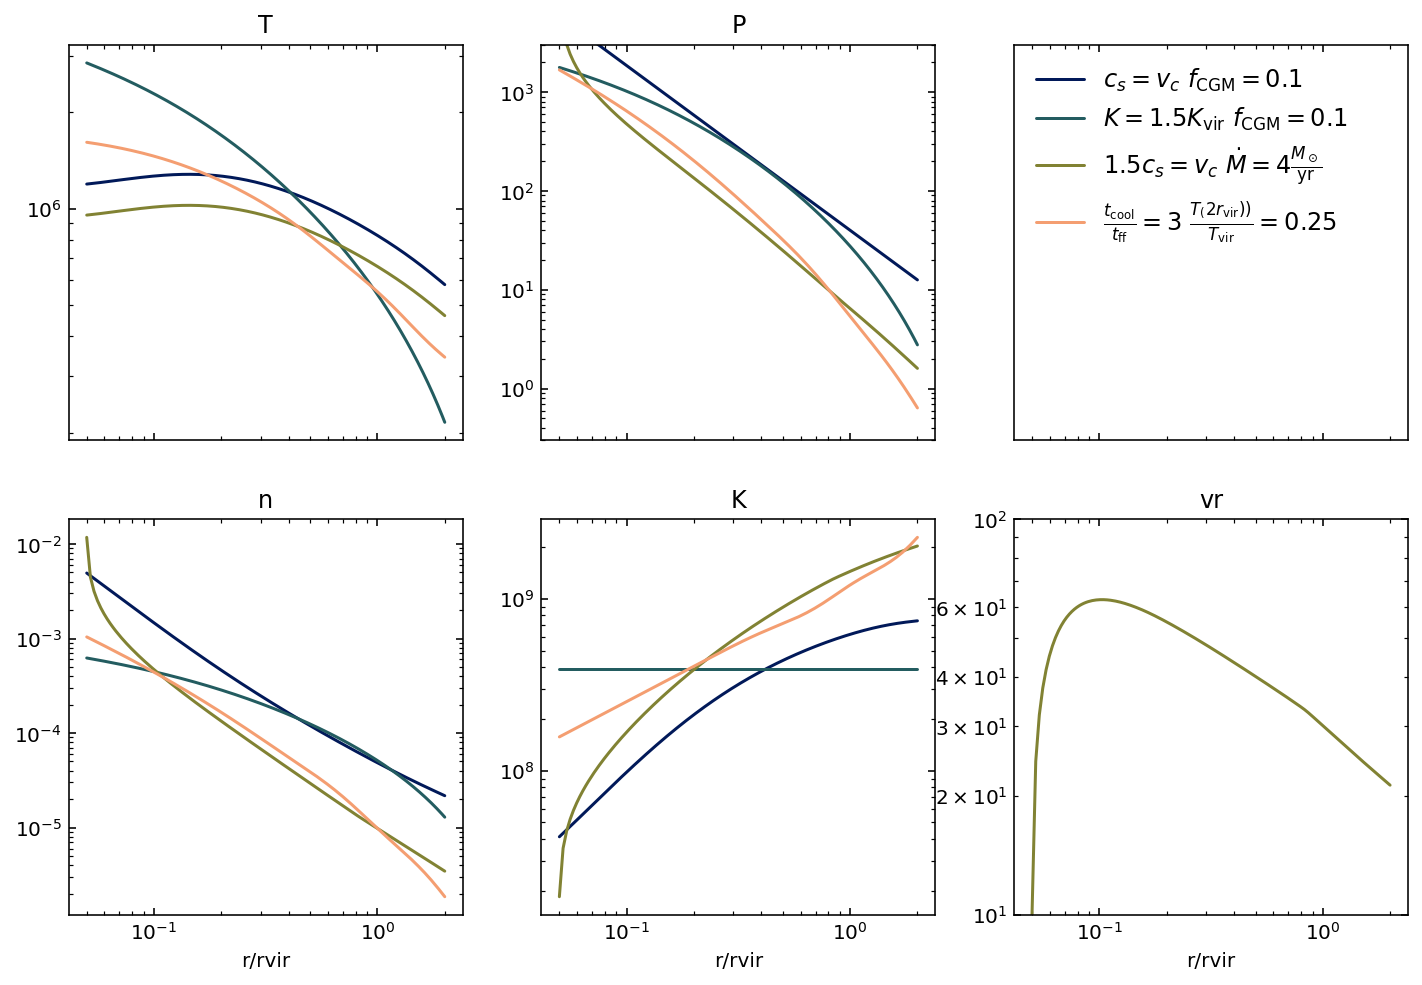

In [16]:

r_inner  = 0.05*rvir*kpc
r_outer  = 2.0*rvir*kpc
radii    = np.linspace(r_inner,r_outer,1000)


fig, axarr = plt.subplots(2,3, sharex=True)
fig.set_size_inches(12,8)

axarr[0,0].loglog(radii/(rvir*kpc), HSE_halo.T(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[0])
axarr[0,1].loglog(radii/(rvir*kpc), HSE_halo.P(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[0])
axarr[1,1].loglog(radii/(rvir*kpc), HSE_halo.K(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[0])
axarr[1,0].loglog(radii/(rvir*kpc), HSE_halo.n(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[0])
# axarr[1,2].loglog(radii/(rvir*kpc), -HSE_halo.vr(radii)/1e5, color=palettable.scientific.sequential.Batlow_5.hex_colors[0])
axarr[0,2].plot(np.nan, np.nan, color=palettable.scientific.sequential.Batlow_5.hex_colors[0], label = r'$c_s = v_c \, \, f_{\rm CGM} = 0.1$')

axarr[0,0].loglog(radii/(rvir*kpc), HSE_adiabat_halo.T(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[1])
axarr[0,1].loglog(radii/(rvir*kpc), HSE_adiabat_halo.P(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[1])
axarr[1,1].loglog(radii/(rvir*kpc), HSE_adiabat_halo.K(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[1])
axarr[1,0].loglog(radii/(rvir*kpc), HSE_adiabat_halo.n(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[1])
# axarr[1,2].loglog(radii/(rvir*kpc), -HSE_adiabat_halo.vr(radii)/1e5, color=palettable.scientific.sequential.Batlow_5.hex_colors[1])
axarr[0,2].plot(np.nan, np.nan, color=palettable.scientific.sequential.Batlow_5.hex_colors[1], label = r'$K = 1.5 K_{\rm vir}  \, \,  f_{\rm CGM} = 0.1$')

axarr[0,0].loglog(radii/(rvir*kpc), cooling_flow_halo.T(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[2])
axarr[0,1].loglog(radii/(rvir*kpc), cooling_flow_halo.P(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[2])
axarr[1,1].loglog(radii/(rvir*kpc), cooling_flow_halo.K(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[2])
axarr[1,0].loglog(radii/(rvir*kpc), cooling_flow_halo.n(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[2])
axarr[1,2].loglog(radii/(rvir*kpc), -cooling_flow_halo.vr(radii)/1e5, color=palettable.scientific.sequential.Batlow_5.hex_colors[2])
axarr[0,2].plot(np.nan, np.nan, color=palettable.scientific.sequential.Batlow_5.hex_colors[2], label = r'$1.5 c_s = v_c \, \,  \dot{M} = 4 \frac{M_\odot}{\rm yr}$')

axarr[0,0].loglog(radii/(rvir*kpc), precipitate_halo.T(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[3])
axarr[0,1].loglog(radii/(rvir*kpc), precipitate_halo.P(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[3])
axarr[1,1].loglog(radii/(rvir*kpc), precipitate_halo.K(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[3])
axarr[1,0].loglog(radii/(rvir*kpc), precipitate_halo.n(radii), color=palettable.scientific.sequential.Batlow_5.hex_colors[3])
# axarr[1,2].loglog(radii/(rvir*kpc), -precipitate_halo.vr(radii)/1e5, color=palettable.scientific.sequential.Batlow_5.hex_colors[3])
axarr[0,2].plot(np.nan, np.nan, color=palettable.scientific.sequential.Batlow_5.hex_colors[3], label = r'$\frac{t_{\rm cool}}{t_{\rm ff}} = 3 \, \,  \frac{T_(2 r_{\rm vir}))}{T_{\rm vir}} = 0.25$')


axarr[0,2].legend(loc='upper left', ncol=1, frameon=False, fontsize=12)
axarr[0,2].set_yticks([])
axarr[0,0].set_title('T')
axarr[0,1].set_title('P')
axarr[1,1].set_title('K')
axarr[1,0].set_title('n')
axarr[1,2].set_title('vr')
axarr[1,1].set_xlabel('r/rvir')
axarr[1,0].set_xlabel('r/rvir')
axarr[1,2].set_xlabel('r/rvir')

axarr[1,2].set_ylim((10,100))
axarr[0,1].set_ylim((0.3,3e3))
axarr[0,1].set_yticks([1,10,100,1000])

In [17]:

datahome = "./data/"

NGAL = np.array([38.e4,126.e4,333.e4,570.e4,442.e4,13.e4])
thta_arc = np.linspace(0.7, 5., 6.) *  1.5 / 1.4

P = Profiles()

# r_inner  = 0.05*rvir*kpc
# r_outer  = 2.0*rvir*kpc
# radii    = np.linspace(r_inner,r_outer,1000)

xx = (np.arange(100) + 1) * 0.02

mu_electron = 1.4 ###???? 
mu = 0.62 


f_cs0 = 1.5
f_CGM0 = 0.1

HSE_halo = HSE(f_cs0,f_CGM0)

rho = HSE_halo.n(xx*rvir*kpc) * mp * mu_electron
pth = HSE_halo.P(xx*rvir*kpc) * mu_electron / mu
intr = P.interpol_sim_profile(xx,rho)
intp = P.interpol_sim_profile(xx,pth)

# theta = (np.arange(10) + 1) * 0.5
r200 = rvir * 1e-3
z = 0.5

projr,projp = P.make_a_obs_profile_sim(thta_arc,r200,z,intr,intp)

delta_f_cs = 0.1
delta_f_CGM = 0.01

HSE_halo = HSE(f_cs0+delta_f_cs,f_CGM0)

rho = HSE_halo.n(xx*rvir*kpc) * mp * mu_electron
pth = HSE_halo.P(xx*rvir*kpc) * mu_electron / mu
intr = P.interpol_sim_profile(xx,rho)
intp = P.interpol_sim_profile(xx,pth)
projr_p1up,projp_p1up = P.make_a_obs_profile_sim(thta_arc,r200,z,intr,intp)

HSE_halo = HSE(f_cs0-delta_f_cs,f_CGM0)

rho = HSE_halo.n(xx*rvir*kpc) * mp * mu_electron
pth = HSE_halo.P(xx*rvir*kpc) * mu_electron / mu
intr = P.interpol_sim_profile(xx,rho)
intp = P.interpol_sim_profile(xx,pth)
projr_p1dn,projp_p1dn = P.make_a_obs_profile_sim(thta_arc,r200,z,intr,intp)

HSE_halo = HSE(f_cs0,f_CGM0+delta_f_CGM)

rho = HSE_halo.n(xx*rvir*kpc) * mp * mu_electron
pth = HSE_halo.P(xx*rvir*kpc) * mu_electron / mu
intr = P.interpol_sim_profile(xx,rho)
intp = P.interpol_sim_profile(xx,pth)
projr_p2up,projp_p2up = P.make_a_obs_profile_sim(thta_arc,r200,z,intr,intp)

HSE_halo = HSE(f_cs0,f_CGM0-delta_f_CGM)

rho = HSE_halo.n(xx*rvir*kpc) * mp * mu_electron
pth = HSE_halo.P(xx*rvir*kpc) * mu_electron / mu
intr = P.interpol_sim_profile(xx,rho)
intp = P.interpol_sim_profile(xx,pth)
projr_p2dn,projp_p2dn = P.make_a_obs_profile_sim(thta_arc,r200,z,intr,intp)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  if sys.path[0] == '':


In [18]:
p1diff = 2*delta_f_cs
p2diff = 2*delta_f_CGM

mu_rp1 = (projr_p1up - projr_p1dn)/p1diff
mu_rp2 = (projr_p2up - projr_p2dn)/p2diff

mu_pp1 = (projp_p1up - projp_p1dn)/p1diff
mu_pp2 = (projp_p2up - projp_p2dn)/p2diff

In [33]:
p_initial = np.array([f_cs0, f_CGM0])

covrho = np.genfromtxt(datahome+"CovMat_CMB_S4-1.5arcmin_beam1.4_Lmax30000.0_2017-03-16.txt")
covpth = np.genfromtxt(datahome+"CovMat_y_S4-1.5arcmin_beam1.4_Lmax30000.0_2017-03-16.txt")

In [34]:
ii = 2 # index 2 in NGALs corresponds to redshift 

covrho /= NGAL[ii]
covpth /= NGAL[ii]

rho_mus = np.transpose([mu_rp1,mu_rp2])
pth_mus = np.transpose([mu_pp1,mu_pp2])

tot_fish_rho = np.dot(np.transpose(rho_mus),np.dot(np.linalg.inv(covrho),rho_mus))
tot_fish_pth = np.dot(np.transpose(pth_mus),np.dot(np.linalg.inv(covpth),pth_mus))

tot_fish = tot_fish_rho + tot_fish_pth

fish_inv = np.linalg.inv(tot_fish)
marginal_pars(p_initial,fish_inv)

print(tot_fish)


1.5 4.75565674819377e-11
0.1 2.0870819410983176e-12
[[4.48150654e+20 1.18069263e+21]
 [1.18069263e+21 2.32683740e+23]]


1.5 2.6060838445831473e-14
0.1 1.143713858466209e-15
2
(2, 2)
test
repeat(None)
repeat(None)
repeat(None)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


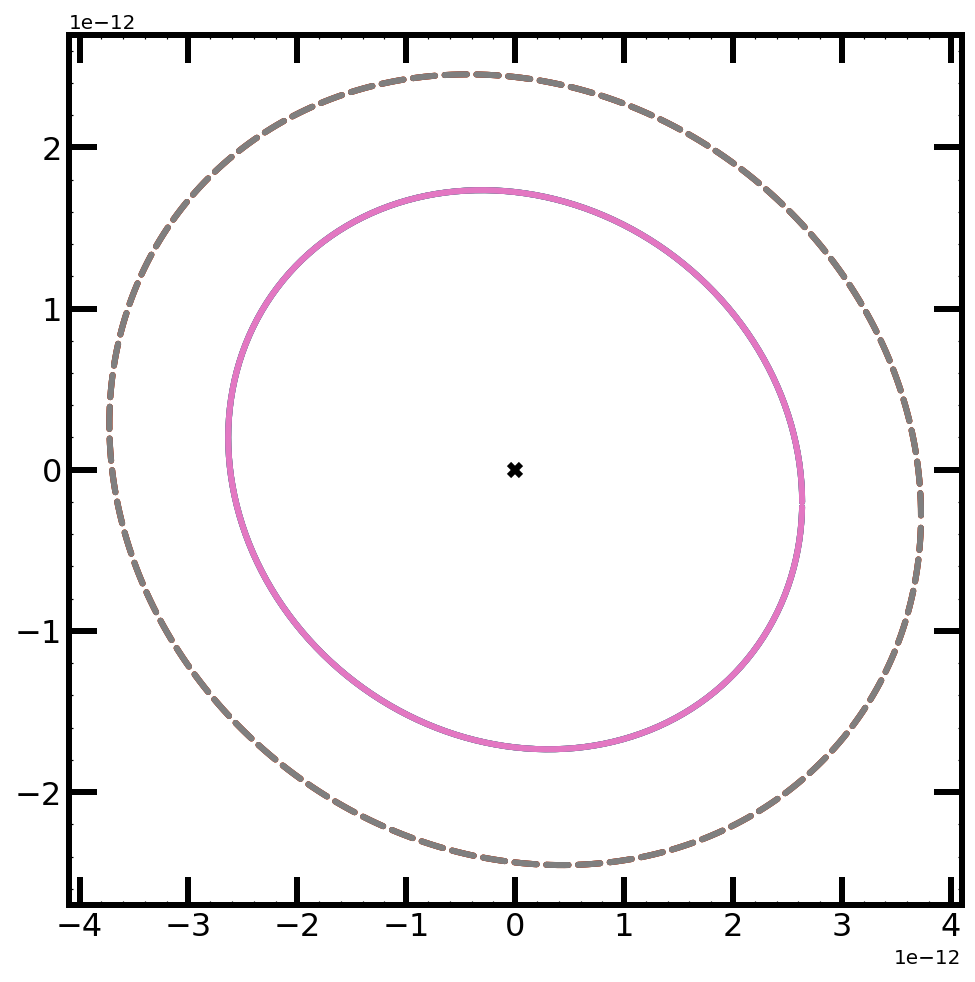

In [35]:

ii = 2 # index 2 in NGALs corresponds to redshift 

covrho /= NGAL[ii]
covpth /= NGAL[ii]

rho_mus = np.transpose([mu_rp1,mu_rp2])
pth_mus = np.transpose([mu_pp1,mu_pp2])

tot_fish_rho = np.dot(np.transpose(rho_mus),np.dot(np.linalg.inv(covrho),rho_mus))
tot_fish_pth = np.dot(np.transpose(pth_mus),np.dot(np.linalg.inv(covpth),pth_mus))

tot_fish = tot_fish_rho + tot_fish_pth

fish_inv = np.linalg.inv(tot_fish)

marginal_pars(p_initial,fish_inv)
tri_plot(p_initial,tot_fish,'test',saveFile='test_fisher.png')


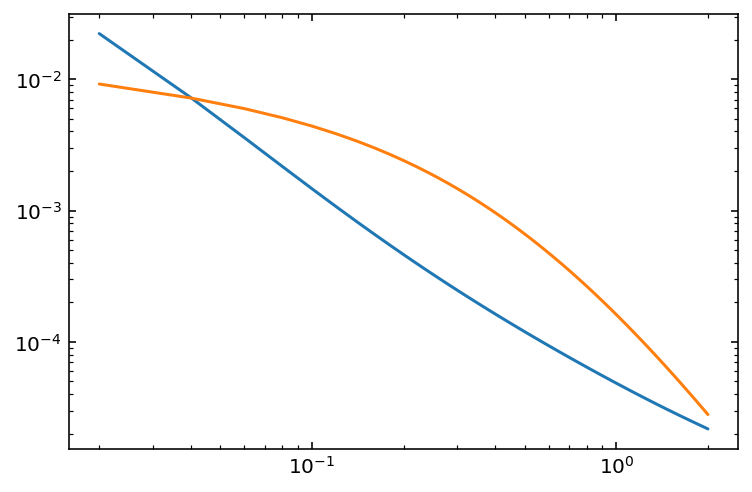

In [37]:
def tri_plot(pars,fishmats,setNames,cols=itertools.repeat(None),lss=itertools.repeat(None),parlabs=itertools.repeat(None),saveFile="default.png",thk=3):
    #
    numpars = len(pars)
    print(numpars)
    plt.figure(figsize=(4*numpars,4*numpars))
    plt.rc('axes', linewidth=thk)
    
    print(np.shape(fishmats))
    bigcount = 0
    print(setNames)
    print(cols)
    print(lss)
    print(parlabs)
    for setName,col,ls,lab in zip(setNames,cols,lss,parlabs):
        if (len(setName) > 1):
            covmat = np.linalg.inv(fishmats[:][bigcount])
        else:
            covmat = np.linalg.inv(fishmats)
        for i in range(0,numpars):
            for j in range(i+1,numpars):
                count = 1+(j-1)*(numpars-1) + i
                chi2 = np.array([[covmat[i,i],covmat[i,j]],[covmat[j,i],covmat[j,j]]])
                ansout, ansout2 = make_elsp(chi2)
                plt.subplot(numpars-1,numpars-1,count)
                if (bigcount == 0): 
                    plt.tick_params(size=14,width=thk,labelsize = 16)
                    plt.plot(0,0,'xk',mew=thk)
#                     if (count ==1):
#                         plt.ylabel(lab[1][:], fontsize=32,weight='bold')
#                     if (count == 3):
#                         plt.ylabel(lab[2][:], fontsize=32,weight='bold')
#                         plt.xlabel(lab[0][:], fontsize=32,weight='bold')
#                     if (count == 4):
#                         plt.xlabel(lab[1][:], fontsize=32,weight='bold')
    
                plt.plot(ansout[0,:]/pars[i]*100. , ansout[1,:]/pars[j]*100.,ansout2[0,:]/pars[i]*100.,ansout2[1,:]/pars[j]*100.,'--',color=col,linewidth=thk)
#                plt.plot(ansout2[0,:]/pars[i]*100. , ansout2[1,:]/pars[j]*100.,'--',color=col,linewidth=thk)
        bigcount = bigcount + 1
        
    plt.savefig(saveFile, bbox_inches='tight',format='png')

    return



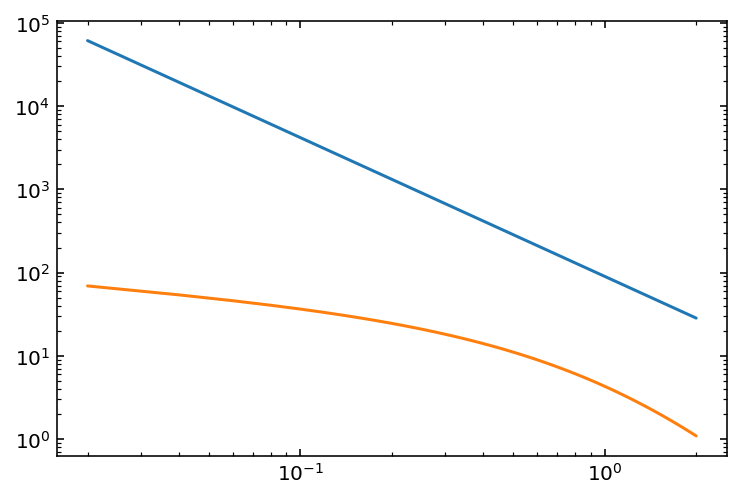

In [39]:
plt.loglog(xx, pth)
plt.loglog(xx, pth_test)